Construction of the ground truth of co-regulated sites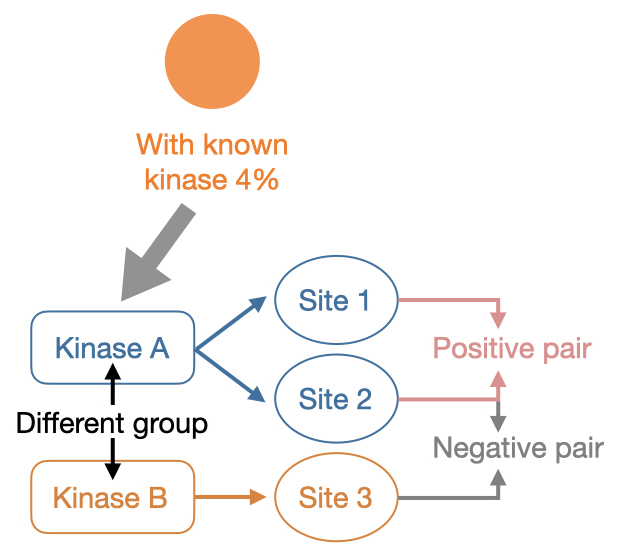

In [8]:
import pandas as pd
import xlrd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import scipy.stats as sts
import random
import seaborn as sns
from statannot import add_stat_annotation
from Bio.Align import substitution_matrices

Part I: Positive phosphosite pairs and negative phosphosite paris generated from gold standard KSAs

In [9]:
#Data Cleaning: Gold standard KSA db

#Kinase name, family, group information
kinases_id=pd.read_excel('KSA/kinase_table.xlsx')
kinases_id.index=kinases_id.Name

#gold standard KSAs
K_S_GPS=pd.read_csv('KSA/KSA_gold_standard.csv',index_col=0)

#All sites identified in the CPTAC PanCan datasets
a_file = open("PanCan/all_sites_id_1cancer.pkl", "rb")
All_sites = pickle.load(a_file)
sites=[i for i in All_sites]
seqs=[i.split('|')[3] for i in sites]

#4873 gold standard KSAs for the sites identified in CPTAC PanCan datasets
K_S_GPS_identified=K_S_GPS[K_S_GPS.seq_15.isin(seqs)]

In [7]:
len(sites)

77442

In [10]:
K_S_GPS_identified.to_csv('../K_S_GPS_identified.csv')

In [2]:
#Filtered: 8 major kinase groups
K_S_GPS_identified=K_S_GPS_identified[K_S_GPS_identified.Group!='Other']

#Leave-one-out kinases:CSNK2A1/CSNK2A2/CSNK1A1 for validation
kinases=list(set(K_S_GPS_identified['Gene name']))
kinases.remove('CSNK2A1')
kinases.remove('CSNK1A1')
kinases.remove('CSNK2A2')
kinases=[i for i in kinases if 'family' not in i]

K_S_GPS_identified=K_S_GPS_identified[K_S_GPS_identified['Gene name'].isin(kinases)]

#At least 2 substrates for each kinase in the gold standard KSAs
kinases_update=[]
for k in kinases:
    tmp=K_S_GPS_identified[K_S_GPS_identified['Gene name']==k]
    if len(tmp)>=2:
        kinases_update.append(k)
K_S_GPS_identified=K_S_GPS_identified[K_S_GPS_identified['Gene name'].isin(kinases_update)]

In [13]:
#Generate all positive pairs and save it to a csv file
pos_site_pairs=[]
for k in kinases_update:
    tmp=K_S_GPS_identified[K_S_GPS_identified['Gene name']==k]
    for i in range(len(tmp)-1):
        for j in range(i+1,len(tmp)):
            if tmp.seq_15.iloc[i]!=tmp.seq_15.iloc[j]:
                pos_site_pairs.append(frozenset([tmp.seq_15.iloc[i],tmp.seq_15.iloc[j]]))
pos_site_pairs=list(set(pos_site_pairs))
print(len(pos_site_pairs))

df=pd.DataFrame()
df['Site1']=[list(s)[0] for s in pos_site_pairs]
df['Site2']=[list(s)[1] for s in pos_site_pairs]
df.to_csv('CoPheeMap/data_construction/gold_standard_site_pair/positive_site_pairs_15mer.csv')

192926


In [697]:
#Generate all negative pairs and save it to a csv file
#Warning: Long running time
#seq_lst=list(set(K_S_GPS_identified.seq_15))
#neg_site_pairs=[]
#for i in range(len(seq_lst)-1):
#    for j in range(i+1,len(seq_lst)):
#        seq1=seq_lst[i]
#        seq2=seq_lst[j]
#        tmp1=K_S_GPS[K_S_GPS['seq_15']==seq1]
#        tmp2=K_S_GPS[K_S_GPS['seq_15']==seq2]
#        if len(set(tmp1.Group).intersection(set(tmp2.Group)))==0:
#            if seq1!=seq2:
#                neg_site_pairs.append(frozenset([seq1,seq2]))
#neg_site_pairs=list(set(neg_site_pairs))
#print(len(neg_site_pairs))

#df=pd.DataFrame()
#df['Site1']=[list(s)[0] for s in neg_site_pairs]
#df['Site2']=[list(s)[1] for s in neg_site_pairs]
#df.to_csv('CoPheeMap/data_construction/gold_standard_site_pair/negative_site_pairs_15mer.csv')

1956116


In [16]:
#Generate 10000+ example negative pairs and save it to a csv file
#Warning: Long running time
seq_lst=list(set(K_S_GPS_identified.seq_15))
neg_site_pairs=[]
for i in range(199):
    for j in range(i+1,200):
        seq1=seq_lst[i]
        seq2=seq_lst[j]
        tmp1=K_S_GPS[K_S_GPS['seq_15']==seq1]
        tmp2=K_S_GPS[K_S_GPS['seq_15']==seq2]
        if len(set(tmp1.Group).intersection(set(tmp2.Group)))==0:
            if seq1!=seq2:
                neg_site_pairs.append(frozenset([seq1,seq2]))
neg_site_pairs=list(set(neg_site_pairs))
print(len(neg_site_pairs))

df=pd.DataFrame()
df['Site1']=[list(s)[0] for s in neg_site_pairs]
df['Site2']=[list(s)[1] for s in neg_site_pairs]
df.to_csv('CoPheeMap/data_construction/gold_standard_site_pair/example_negative_site_pairs_15mer.csv')

13144


In [24]:
#Generate 10000 example random pairs and save it to a csv file
sites=[i for i in All_sites]
seqs=[i.split('|')[3] for i in sites]
seq_rd1=random.sample(seqs,100)
seq_rd2=random.sample(seqs,100)
rd_site_pairs=[]
for s1 in seq_rd1:
    for s2 in seq_rd2:
        if s1!=s2:
            if frozenset([s1,s2]) not in pos_site_pairs:
                rd_site_pairs.append(frozenset([s1,s2]))
rd_site_pairs=list(set(rd_site_pairs))
print(len(rd_site_pairs))

df=pd.DataFrame()
df['Site1']=[list(s)[0] for s in rd_site_pairs]
df['Site2']=[list(s)[1] for s in rd_site_pairs]
df.to_csv('CoPheeMap/data_construction/gold_standard_site_pair/example_random_site_pairs_15mer.csv')

9998


In [ ]:
#Load positive, negative and random site pairs from existing csv files
data=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pair/positive_site_pairs_15mer.csv',index_col=0)
pos_site_pairs=[]
for i in range(len(data)):
    seq1=data.iloc[i,0]
    seq2=data.iloc[i,1]
    pos_site_pairs.append(frozenset([seq1,seq2]))
    
data=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pair/example_negative_site_pairs_15mer.csv',index_col=0)
neg_site_pairs=[]
for i in range(len(data)):
    seq1=data.iloc[i,0]
    seq2=data.iloc[i,1]
    neg_site_pairs.append(frozenset([seq1,seq2]))
    
data=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pair/example_random_site_pairs_15mer.csv',index_col=0)
rd_site_pairs=[]
for i in range(len(data)):
    seq1=data.iloc[i,0]
    seq2=data.iloc[i,1]
    rd_site_pairs.append(frozenset([seq1,seq2]))
rd_site_pairs=list(set(rd_site_pairs).difference(set(pos_site_pairs)))

Part II: Features calculation: sequence similarities; kinase interaction profile similarities; PCCs

In [2]:
#example data
combined_cancer_pos=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pair/example_combined_cancer_pos.csv',index_col=0)
combined_cancer_neg=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pair/example_combined_cancer_neg.csv',index_col=0)

In [11]:
#Calculate sequence similarities
blosum = substitution_matrices.load('BLOSUM62')
def score_match(pair, matrix):
    if pair not in matrix:
        return matrix[(tuple(reversed(pair)))]
    else:
        return matrix[pair]
def score_pairwise(seq1, seq2, matrix, gap_s, gap_e):
    score = 0
    gap = False
    for i in range(len(seq1)):
        pair = (seq1[i], seq2[i])
        if not gap:
            if ('_' in pair):
                gap = True
                score += gap_s
            else:
                score += score_match(pair, matrix)
        else:
            if '_' not in pair:
                gap = False
                score += score_match(pair, matrix)
            else:
                score += gap_e
    return score
data=combined_cancer_pos
data['seq_simi']=np.repeat(np.nan,len(data))

#Sequence similarities
simi=[]
for i in range(len(data)):
    name1=data.index[i].split('*')[0]
    name2=data.index[i].split('*')[1]
    seq1=name1.split('|')[3]
    seq2=name2.split('|')[3]
    seq1=seq1[0:7]+'_'+seq1[8:16]
    seq2=seq2[0:7]+'_'+seq2[8:16]
    simi.append(score_pairwise(seq1, seq2, blosum, 0, 0))
data['seq_simi']=np.array(simi)

In [22]:
#Calculate kinase interaction profile similarities
#List 1 = kinases interact with the host protein of site 1 in STRING db
#List 2 = kinases interact with the host protein of site 2 in STRING db
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return float(intersection) / union

with open('PPI/PPI_kinase_400.pkl', 'rb') as f:
    dict_PPI_400 = pickle.load(f)
    
#kinase interaction profile similarities
PPI_1=[]
PPI_2=[]
j_index=[]
j_index2=[]
pro_list1=list(dict_PPI_400.keys())
data=combined_cancer_pos
#data=combined_cancer_neg
for i in range(len(data)):
    name1=data.index[i].split('*')[0]
    name2=data.index[i].split('*')[1]
    pro1=name1.split('|')[1]
    pro2=name2.split('|')[1]
    pro1=pro1.split('.')[0]
    pro2=pro2.split('.')[0]
    pro1='.'.join(['9606',pro1])
    pro2='.'.join(['9606',pro2])
    if (pro1 in pro_list1)  and (pro2 in pro_list1):
        lst1=list(dict_PPI_400[pro1].values())[0]
        lst2=list(dict_PPI_400[pro2].values())[0]
        j_index.append(jaccard(lst1,lst2))
    else:
        j_index.append(np.nan)
data['PPI']=np.array(j_index)

In [ ]:
import pandas as pd
import numpy as np
#Calculate PCCs
def corr_all_sites(data):
    #First step filtering
    #At least 20% samples quantified for each site
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    idx_80=[]
    for k in range(len(data)):
        if sum(data.iloc[k,:].isna())/len(data.iloc[0,:])<=0.8:
            idx_80.append(k)
    data=data.iloc[idx_80,:]
    
    #Correlation data could be huge, so in case of running out of memory, we can split the files.
    lst=range(0,len(data),500)
    lst=[i for i in lst]+[len(data)]
    for p in range(len(lst)-1):
        print(p)
        Site1=[]
        Site2=[]
        cor=[]
        for i in range(lst[p],lst[p+1]):
            for j in range(i+1,len(data)):
                a=data.iloc[i].tolist()
                b=data.iloc[j].tolist()
                site1=data.index[i]
                site2=data.index[j]
                bad = ~np.logical_or(np.isnan(a), np.isnan(b))
                if len(np.compress(bad, a))>=20:
                    c=sts.pearsonr(np.compress(bad, a),np.compress(bad, b))[0]
                    if c!=1:
                        cor.append(c)
                        Site1.append(site1)
                        Site2.append(site2)
        df=pd.DataFrame({'site1':Site1,'site2':Site2,'pcc':cor})
        file_name=''.join(['CoPheeMap/data_construction/all_pcc/sample_all_pcc_',str(p),'.csv'])
        df.to_csv(file_name)

data=pd.read_table('CoPheeMap/sample_data/data_phospho.cct',index_col=0)
corr_all_sites(data)

Construction of training, testing and validation data
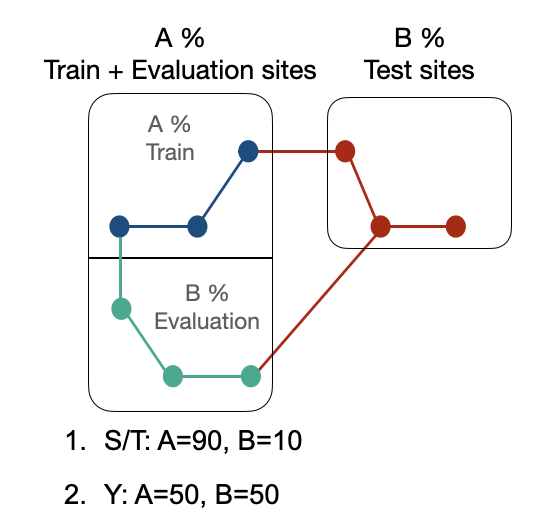

In [49]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV,ParameterGrid

In [50]:
#example data
combined_cancer_pos=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pair/example_combined_cancer_pos.csv',index_col=0)
combined_cancer_neg=pd.read_csv('CoPheeMap/data_construction/gold_standard_site_pair/example_combined_cancer_neg.csv',index_col=0)

combined_cancer_pos['Site1']=np.array([k.split('*')[0] for k in combined_cancer_pos.index])
combined_cancer_pos['Site2']=np.array([k.split('*')[1] for k in combined_cancer_pos.index])
combined_cancer_neg['Site1']=np.array([k.split('*')[0] for k in combined_cancer_neg.index])
combined_cancer_neg['Site2']=np.array([k.split('*')[1] for k in combined_cancer_neg.index])

In [53]:
#Hyperparameter tuning
#example data
#Preparation
pos_train_num=[]
pos_test_num=[]
Y_prediction=[]
Y_test=[]
neg_test_num=[]

data_pos=combined_cancer_pos
data_neg=combined_cancer_neg

data_neg=data_neg[(data_pos.columns)]
data_neg=data_neg.drop(['Site1','Site2'],axis=1)

#Shuffle the negatives
data_neg=data_neg.sample(frac=1)
data_pos_ST=data_pos[data_pos['STY']==1]
data_pos_Y=data_pos[data_pos['STY']==0]
data_neg_ST=data_neg[data_neg['STY']==1]
data_neg_Y=data_neg[data_neg['STY']==0]

s1=random.sample(list(set(data_pos_ST.Site1).union(set(data_pos_ST.Site2))),int(0.9*len(set(data_pos_ST.Site1).union(set(data_pos_ST.Site2)))))
s2=[i for i in list(set(data_pos_ST.Site1).union(set(data_pos_ST.Site2))) if i not in s1]
s3=random.sample(list(set(data_pos_Y.Site1).union(set(data_pos_Y.Site2))),int(0.5*len(set(data_pos_Y.Site1).union(set(data_pos_Y.Site2)))))
s4=[i for i in list(set(data_pos_Y.Site1).union(set(data_pos_Y.Site2))) if i not in s3]

index_train=[]
index_test=[]
for i in range(len(data_pos)):
    if (data_pos.Site1.iloc[i] in s1) and (data_pos.Site2.iloc[i] in s1):
        index_train.append(i)
    if (data_pos.Site1.iloc[i] in s3) and (data_pos.Site2.iloc[i] in s3):
        index_train.append(i)
    if (data_pos.Site1.iloc[i] in s2) and (data_pos.Site2.iloc[i] in s2):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s1) and (data_pos.Site2.iloc[i] in s2):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s2) and (data_pos.Site2.iloc[i] in s1):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s4) and (data_pos.Site2.iloc[i] in s4):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s3) and (data_pos.Site2.iloc[i] in s4):
        index_test.append(i)
    if (data_pos.Site1.iloc[i] in s4) and (data_pos.Site2.iloc[i] in s3):
        index_test.append(i)
pos_train_num.append(len(index_train))
pos_test_num.append(len(index_test))
data_pos_train=data_pos.iloc[index_train]
data_pos_test=data_pos.iloc[index_test]
data_pos_test=data_pos_test.drop(['Site1','Site2'],axis=1)
#idx_train=random.sample(data_neg_Y.index.tolist(),300)
#idx_train_eval=random.sample(idx_train,79)
idx_train=random.sample(data_neg_Y.index.tolist(),1)
idx_train_eval=random.sample(idx_train,1)
idx_test=[i for i in data_neg_Y.index.tolist() if i not in idx_train]
idx_train=[i for i in idx_train if i not in idx_train_eval]

data_neg_Y_train=data_neg_Y[data_neg_Y.index.isin(idx_train)]
data_neg_Y_train_eval=data_neg_Y[data_neg_Y.index.isin(idx_train_eval)]
data_neg_Y_test=data_neg_Y[data_neg_Y.index.isin(idx_test)]
data_neg_Y_test=data_neg_Y_test.sample(frac=1)

data_pos_train_ST=data_pos_train[data_pos_train['STY']==1]
data_pos_train_Y=data_pos_train[data_pos_train['STY']==0]

Construction of CoPheeMap

Features for CoPheeMap: 1)Sequence similarities; 2)Kinase interaction profile similarities 3) Phosphosite correlations

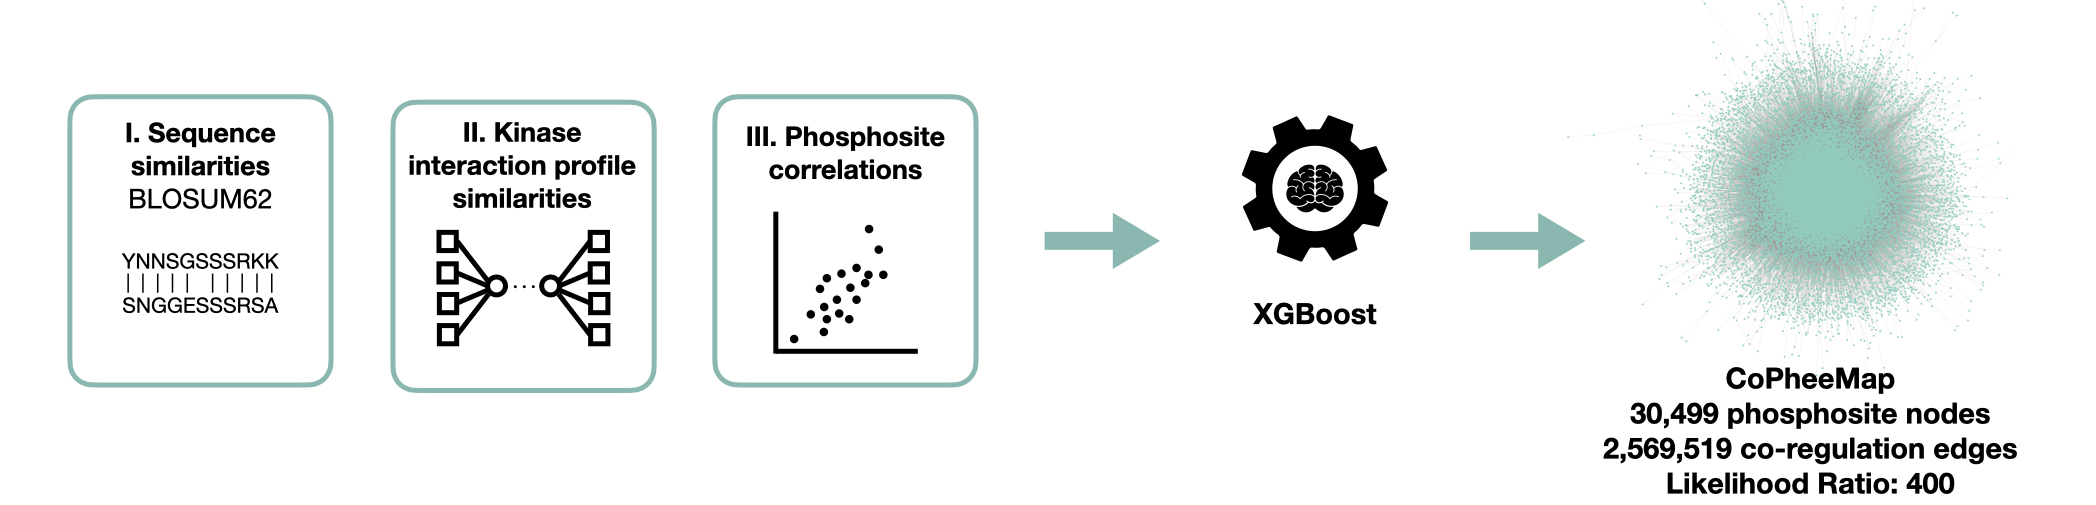

In [54]:
#XGBoost
#Hyperparameter tuning
#Just to run example data for case showing

#select_feature=['PCC_BRCA','PCC_CCRCC','PCC_GBM','PCC_HCC','PCC_HNSCC','PCC_LSCC','PCC_LUAD','PCC_UCEC','seq_simi','PPI','STY']
params = { 'max_depth': [3,4,5,6,7,8],
           'learning_rate': [0.05,0.1,0.15,0.2],
          'objective': ['binary:logistic'],
          'nthread':[8],
           'eval_metric':['aucpr']}
auprc_result=[]
auroc_result=[]
for p in ParameterGrid(params):
    auc_precision_recall=[]
    auc_curve=[]
    for n in range(5):
        s1=random.sample(list(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2))),int(0.9*len(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2)))))
        s2=[i for i in list(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2))) if i not in s1]
        s3=random.sample(list(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2))),int(0.5*len(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2)))))
        s4=[i for i in list(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2))) if i not in s3]
        index_train=[]
        index_test=[]
        for i in range(len(data_pos_train)):
            if (data_pos_train.Site1.iloc[i] in s1) and (data_pos_train.Site2.iloc[i] in s1):
                index_train.append(i)
            if (data_pos_train.Site1.iloc[i] in s2) and (data_pos_train.Site2.iloc[i] in s2):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s1) and (data_pos_train.Site2.iloc[i] in s2):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s2) and (data_pos_train.Site2.iloc[i] in s1):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s3) and (data_pos_train.Site2.iloc[i] in s3):
                index_train.append(i)
            if (data_pos_train.Site1.iloc[i] in s4) and (data_pos_train.Site2.iloc[i] in s4):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s3) and (data_pos_train.Site2.iloc[i] in s4):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s4) and (data_pos_train.Site2.iloc[i] in s3):
                index_test.append(i)

        data_pos_train_train=data_pos_train.iloc[index_train]
        data_pos_train_eval=data_pos_train.iloc[index_test]
        data_pos_train_train=data_pos_train_train.drop(['Site1','Site2'],axis=1)
        data_pos_train_eval=data_pos_train_eval.drop(['Site1','Site2'],axis=1)

        X_train = pd.concat([data_pos_train_train.iloc[:,:],data_neg_ST.iloc[0:5*len(data_pos_train_train),:]])
        X_train = pd.concat([X_train,data_neg_Y_train])
        #X_train=X_train[select_feature]

        X_train_eval = pd.concat([data_pos_train_eval.iloc[:,:],data_neg_ST.iloc[5*len(data_pos_train_train):5*len(data_pos_train_train)+5*len(data_pos_train_eval),:]])
        X_train_eval = pd.concat([X_train_eval,data_neg_Y_train_eval])
        #X_train_eval=X_train_eval[select_feature]
        #X_test = pd.concat([data_pos_test.iloc[:,:],data_neg_ST.iloc[5*len(data_pos_train_train)+5*len(data_pos_train_eval):,:]])
        #X_test = pd.concat([X_test,data_neg_Y_test])
        #X_test=X_test[select_feature]
        y_train = np.concatenate((np.repeat(1,len(data_pos_train_train)),np.repeat(0,len(X_train)-len(data_pos_train_train))))
        y_train_eval = np.concatenate((np.repeat(1,len(data_pos_train_eval)),np.repeat(0,len(X_train_eval)-len(data_pos_train_eval))))
        #y_test = np.concatenate((np.repeat(1,len(data_pos_test)),np.repeat(0,len(X_test)-len(data_pos_test))))

        dtrain_train = xgb.DMatrix(X_train, label=y_train)
        dtrain_eval = xgb.DMatrix(X_train_eval, label=y_train_eval)
        #dtest = xgb.DMatrix(X_test, label=y_test)

        evallist = [(dtrain_train, 'train') , (dtrain_eval, 'eval')]
        num_round = 200
        bst = xgb.train(p, dtrain_train, num_round, evallist,verbose_eval=False,early_stopping_rounds=10)
        y_pred = bst.predict(dtrain_eval)
        precision, recall, thresholds = metrics.precision_recall_curve(y_train_eval, y_pred)
        auc_precision_recall.append(auc(recall, precision))
        fpr, tpr, thresholds = metrics.roc_curve(y_train_eval, y_pred)
        auc_curve.append(auc(fpr, tpr))
    auprc_result.append(auc_precision_recall)
    auroc_result.append(auc_curve)
    #y_pred = bst.predict(dtest)
    #Y_prediction.append(y_pred)
    #Y_test.append(y_test)

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/co

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/co

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/co

In [56]:
#XGBoost with seleted params
#Just to run example data for case showing
params = { 'max_depth': [4],
           'learning_rate': [0.15],
          'objective': ['binary:logistic'],
          'nthread':[8],
           'eval_metric':['aucpr']}
auprc_result=[]
auroc_result=[]
mean_fpr = np.linspace(0, 1, 100)
for p in ParameterGrid(params):
    
    auc_precision_recall=[]
    auc_curve=[]
    fprs_forplot=[]
    tprs_forplot=[]
    tprs=[]
    aucs=[]
    auc_curve_static=[]
    fprs_forplot_static=[]
    tprs_forplot_static=[]
    tprs_static=[]
    aucs_static=[]
    
    auc_curve_dynamic=[]
    fprs_forplot_dynamic=[]
    tprs_forplot_dynamic=[]
    tprs_dynamic=[]
    aucs_dynamic=[]
    for n in range(1):
        s1=random.sample(list(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2))),int(0.9*len(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2)))))
        s2=[i for i in list(set(data_pos_train_ST.Site1).union(set(data_pos_train_ST.Site2))) if i not in s1]
        s3=random.sample(list(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2))),int(0.5*len(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2)))))
        s4=[i for i in list(set(data_pos_train_Y.Site1).union(set(data_pos_train_Y.Site2))) if i not in s3]
        index_train=[]
        index_test=[]
        for i in range(len(data_pos_train)):
            if (data_pos_train.Site1.iloc[i] in s1) and (data_pos_train.Site2.iloc[i] in s1):
                index_train.append(i)
            if (data_pos_train.Site1.iloc[i] in s2) and (data_pos_train.Site2.iloc[i] in s2):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s1) and (data_pos_train.Site2.iloc[i] in s2):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s2) and (data_pos_train.Site2.iloc[i] in s1):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s3) and (data_pos_train.Site2.iloc[i] in s3):
                index_train.append(i)
            if (data_pos_train.Site1.iloc[i] in s4) and (data_pos_train.Site2.iloc[i] in s4):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s3) and (data_pos_train.Site2.iloc[i] in s4):
                index_test.append(i)
            if (data_pos_train.Site1.iloc[i] in s4) and (data_pos_train.Site2.iloc[i] in s3):
                index_test.append(i)

        data_pos_train_train=data_pos_train.iloc[index_train]
        data_pos_train_eval=data_pos_train.iloc[index_test]
        data_pos_train_train=data_pos_train_train.drop(['Site1','Site2'],axis=1)
        data_pos_train_eval=data_pos_train_eval.drop(['Site1','Site2'],axis=1)

        X_train = pd.concat([data_pos_train_train.iloc[:,:],data_neg_ST.iloc[0:5*len(data_pos_train_train),:]])
        X_train = pd.concat([X_train,data_neg_Y_train])
        X_train=X_train.iloc[:,0:]
        X_train_static=X_train[['seq_simi', 'PPI', 'STY']]
        X_train_dynamic=X_train.iloc[:,0:11]


        X_train_eval = pd.concat([data_pos_train_eval.iloc[:,:],data_neg_ST.iloc[5*len(data_pos_train_train):5*len(data_pos_train_train)+5*len(data_pos_train_eval),:]])
        X_train_eval = pd.concat([X_train_eval,data_neg_Y_train_eval])
        X_train_eval=X_train_eval.iloc[:,0:]
        X_train_static_eval=X_train_eval[['seq_simi', 'PPI', 'STY']]
        X_train_dynamic_eval=X_train_eval.iloc[:,0:11]

        X_test = pd.concat([data_pos_test.iloc[:,:],data_neg_ST.iloc[5*len(data_pos_train_train)+5*len(data_pos_train_eval):5*len(data_pos_train_train)+5*len(data_pos_train_eval)+50*len(data_pos_test),:]])
        X_test = pd.concat([X_test,data_neg_Y_test])
        pairs_site=X_test.index.tolist()
        X_test=X_test.iloc[:,0:]
        X_test_static=X_test[['seq_simi', 'PPI', 'STY']]
        X_test_dynamic=X_test.iloc[:,0:11]

        y_train = np.concatenate((np.repeat(1,len(data_pos_train_train)),np.repeat(0,len(X_train)-len(data_pos_train_train))))
        y_train_eval = np.concatenate((np.repeat(1,len(data_pos_train_eval)),np.repeat(0,len(X_train_eval)-len(data_pos_train_eval))))
        y_test = np.concatenate((np.repeat(1,len(data_pos_test)),np.repeat(0,len(X_test)-len(data_pos_test))))

        
        dtrain_train = xgb.DMatrix(X_train, label=y_train)
        dtrain_eval = xgb.DMatrix(X_train_eval, label=y_train_eval)
        dtest = xgb.DMatrix(X_test, label=y_test)
        
        dtrain_train_static = xgb.DMatrix(X_train_static, label=y_train)
        dtrain_eval_static = xgb.DMatrix(X_train_static_eval, label=y_train_eval)
        dtest_static = xgb.DMatrix(X_test_static, label=y_test)
        
        dtrain_train_dynamic = xgb.DMatrix(X_train_dynamic, label=y_train)
        dtrain_eval_dynamic = xgb.DMatrix(X_train_dynamic_eval, label=y_train_eval)
        dtest_dynamic = xgb.DMatrix(X_test_dynamic, label=y_test)

        evallist = [(dtrain_train, 'train'),(dtrain_eval, 'eval')]
        num_round = 200
        bst = xgb.train(p, dtrain_train, num_round, evallist,verbose_eval=False,early_stopping_rounds=10)
        #bst.save_model('CoPheeMap/model/xgboost.json')
        y_pred = bst.predict(dtest)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
        auc_curve.append(auc(fpr, tpr))
        fprs_forplot.append(fpr)
        tprs_forplot.append(tpr)
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        aucs.append(auc(fpr, tpr))
        
        evallist = [(dtrain_train_static, 'train'),(dtrain_eval_static, 'eval')]
        num_round = 200
        bst = xgb.train(p, dtrain_train_static, num_round, evallist,verbose_eval=False,early_stopping_rounds=10)
        y_pred_static = bst.predict(dtest_static)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_static)
        auc_curve_static.append(auc(fpr, tpr))
        fprs_forplot_static.append(fpr)
        tprs_forplot_static.append(tpr)
        tprs_static.append(np.interp(mean_fpr, fpr, tpr))
        aucs_static.append(auc(fpr, tpr))
        
        
        evallist = [(dtrain_train_dynamic, 'train'),(dtrain_eval_dynamic, 'eval')]
        num_round = 200
        bst = xgb.train(p, dtrain_train_dynamic, num_round, evallist,verbose_eval=False,early_stopping_rounds=10)
        y_pred_dynamic = bst.predict(dtest_dynamic)

        fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_dynamic)
        auc_curve_dynamic.append(auc(fpr, tpr))
        fprs_forplot_dynamic.append(fpr)
        tprs_forplot_dynamic.append(tpr)
        tprs_dynamic.append(np.interp(mean_fpr, fpr, tpr))
        aucs_dynamic.append(auc(fpr, tpr))

    auprc_result.append(auc_precision_recall)
    auroc_result.append(auc_curve)

X_test.index=pairs_site
#X_test.to_csv('CoPheeMap/model/test_data.csv',index=True)
#pd.DataFrame(y_test).to_csv('CoPheeMap/model/test_label.csv')

/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)
/Users/klml322/anaconda3/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [75]:
#model-ready-to-use applied on example test data and test label
bst = xgb.Booster()
bst.load_model("CoPheeMap/model/xgboost.json")
X_test=pd.read_csv('CoPheeMap/model/example_test_data.csv',index_col=0)
y_test=pd.read_csv('CoPheeMap/model/example_test_label.csv',index_col=0)

dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = bst.predict(dtest)
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
auc(fpr, tpr)

[07:08:50] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/learner.cc:888: Found JSON model saved before XGBoost 1.6, please save the model using current version again. The support for old JSON model will be discontinued in XGBoost 2.3.


0.7755804303968209

In [ ]:
#Load CoPheeMap

In [101]:
network=pd.read_excel('Supplementary_table/Table_S2.xlsx',sheet_name='CoPheeMap')

In [103]:
import networkx as nx
from operator import itemgetter
from networkx.algorithms import community

In [106]:
#CoPheeMap
seq1=[i.split('|')[3] for i in network.site1.tolist()]
seq2=[i.split('|')[3] for i in network.site2.tolist()]
network['seq1']=np.array(seq1)
network['seq2']=np.array(seq2)
sites=list(set(network.site1.tolist()+network.site2.tolist()))
G = nx.Graph()
elist=list(zip(network.site1.tolist(),network.site2.tolist()))
G.add_edges_from(elist)

idx_ST=[]
idx_Y=[]
for i in range(len(network)):
    if network.seq1.iloc[i][7] in ['S','T']:
        idx_ST.append(i)
    if network.seq1.iloc[i][7] in ['Y']:
        idx_Y.append(i)
network_ST=network.iloc[idx_ST,:]
network_Y=network.iloc[idx_Y,:]
lst_ST=list(set(network_ST.site1.tolist()+network_ST.site2.tolist()))
H=G.subgraph(lst_ST)
nodes_ST=max(nx.connected_components(H))
G_ST=G.subgraph(nodes_ST)
network_Y=network.iloc[idx_Y,:]
lst_Y=list(set(network_Y.site1.tolist()+network_Y.site2.tolist()))
H=G.subgraph(lst_Y)
nodes_Y=max(nx.connected_components(H))
G_Y=G.subgraph(nodes_Y)

In [107]:
sites=list(set(network.site1.tolist()+network.site2.tolist()))
len(sites)
len(network)

764049